# Modelo de classificação - Campanha de marketing de uma instituição bancária

Os dados referem-se a campanhas de marketing de uma instuição bancária portuguesa realizadas entre 2008 e 2010. O objetivo é prever se o cliente fará um depósito a prazo.

Visando facilitar a análise dos dados, desenvolvi um dashboard que pode ser acessado em [Dashboard de Marketing](https://app.powerbi.com/view?r=eyJrIjoiYjJlMjQxYWQtMTZlYy00ZDYzLWFhYWMtOTM4ZTQ4YTg1NTFlIiwidCI6ImUxYWFhM2NmLTI5MjItNDEyYy04MDE1LWRlZTEyZDg1MTJmYSJ9&pageName=ReportSectionac001f34a9fc80bde708).

O conjunto de dados pode ser obtido em: <https://archive.ics.uci.edu/ml/datasets/Bank+Marketing>.

**Fonte**

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## Resumo
* Importação das principais bibliotecas e carregamento dos dados
* Análise inicial
* Relação entre as variáveis independentes numéricas
* Tratamento dos dados
 * Detecção de outliers
 * Balanceamento das classes
* Modelo de classificação - Random Forest
* Validação do modelo
* Principais variáveis
* Predição de um novo registro


## Importação das principais bibliotecas e carregamento dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_theme(style = 'darkgrid')
from collections import Counter

In [2]:
dataset = pd.read_csv('bank-additional-full.csv', delimiter=';')

## Análise Inicial

In [3]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
dataset.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Não há valores nulos

In [6]:
dataset.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Atenção aos valores das colunas 'duration' e 'campaign': ambas possuem o 3º quartil e valor máximo muito distantes.

In [7]:
dataset['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Variável dependente desbalanceada. Necessário tratamento para correção.

## Relação entre as variáveis independentes numéricas

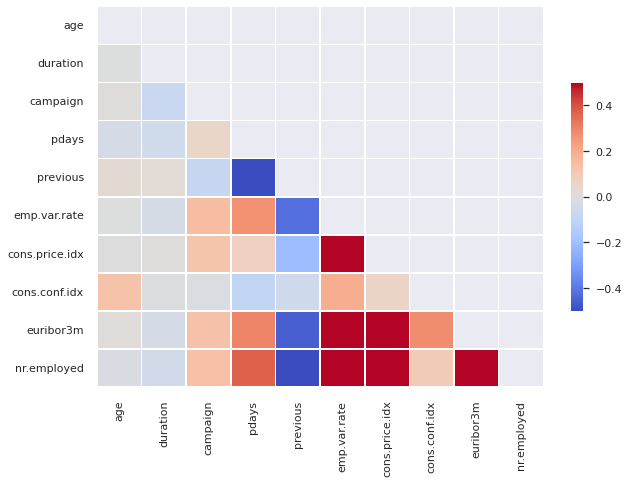

In [8]:
dt_corr = dataset.corr()
dt_mask = np.zeros_like(dt_corr, dtype=np.bool)
dt_mask[np.triu_indices_from(dt_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(dt_corr, mask=dt_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

Alta relação positiva entre as variáveis econômicas e sociais (emp.var.rate, cons.price.idx, cons.conf.idx e euribor3m)

## Tratamento dos dados

In [9]:
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

In [10]:
# Conversão dos dados categóricos
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 5, 6, 7, 8, 9, 14])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [11]:
# Conversão da variável dependente de categórica para numérica
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [12]:
# Divisão dos dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Detecção de Outliers

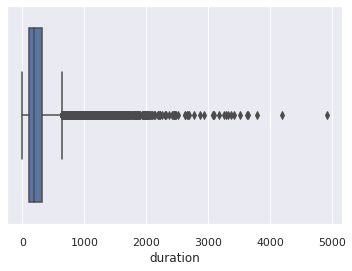

In [13]:
sns.boxplot(x=dataset['duration'])

Como observado anteriormente, existe um grande intervalo entre o 3º quartil e o valor máximo.

O gráfico acima demonstra isso e evidencia a existência de outliers.

In [14]:
from sklearn.ensemble import IsolationForest

print(X_train.shape, y_train.shape)
print(Counter(y_train))

# identificação de outliers no conjunto de treino
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train[:, [54, 55, 57, 59, 60, 61, 62]])

# seleção dos registros que não são outliers
mask = yhat != -1
X_train_wt_outliers, y_train_wt_outliers = X_train[mask, :],  y_train[mask]

print(X_train_wt_outliers.shape, y_train_wt_outliers.shape)
print(Counter(y_train_wt_outliers))

(32950, 63) (32950,)
Counter({0: 29229, 1: 3721})
(29657, 63) (29657,)
Counter({0: 27350, 1: 2307})


Um problema comum em conjuntos de dados que possuem a variável dependente desbalanceada é, durante o tratamento de outliers, perder informações relacionadas a classe de interesse (cliente que realizou depósito a prazo).

Normalmente nesses casos o modelo perde desempenho após o tratamento. Devido a isso (e após testes), foi optado por manter os outliers.

### Balanceamento

In [15]:
# balanceamento do conjunto de treino
from imblearn.over_sampling import RandomOverSampler
print(Counter(y_train))
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(Counter(y_train))

Counter({0: 29229, 1: 3721})
Counter({0: 29229, 1: 29229})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Como há poucos dados da classe de interesse optou-se pela técnica de oversampling. 

## Modelo de Classificação - Random Forest

In [16]:
hyperparameter_space = {'n_estimators': [50, 70, 100, 120],
                        'max_features': [20, 25, 30, 35, 40],
                        'min_samples_leaf':[2,4,6,8,10,12]}

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(classifier, param_distributions=hyperparameter_space,
                        n_iter=30, random_state=0,
                        n_jobs=-1, cv=5)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [17]:
rs.best_params_

{'max_features': 30, 'min_samples_leaf': 2, 'n_estimators': 100}

In [18]:
classifier = rs.best_estimator_

## Validação do Modelo

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate

scores = cross_val_score(classifier, X_train, y_train, cv=5)
print("accuracy: ", scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(classifier, X_train, y_train, scoring=scoring)
print("recall: ", scores['test_recall_macro'])
print("precision: ", scores['test_precision_macro'])

accuracy:  [0.96074239 0.95886076 0.95903182 0.95894278 0.96073903]
0.96 accuracy with a standard deviation of 0.00
recall:  [0.96125556 0.95851865 0.95911735 0.95937387 0.96124899]
precision:  [0.96370633 0.96159175 0.96205328 0.9623183  0.96394373]


O modelo apresenta altos valores de acurácia, precisão e recall no conjunto de treino.

In [20]:
from sklearn.metrics import classification_report
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7319
           1       0.58      0.73      0.65       919

    accuracy                           0.91      8238
   macro avg       0.77      0.83      0.80      8238
weighted avg       0.92      0.91      0.92      8238



No conjunto de teste o modelo também apresenta bom desempenho, conseguindo inclusive identificar relativamente bem a classe de interesse (73%).

## Principais Variáveis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


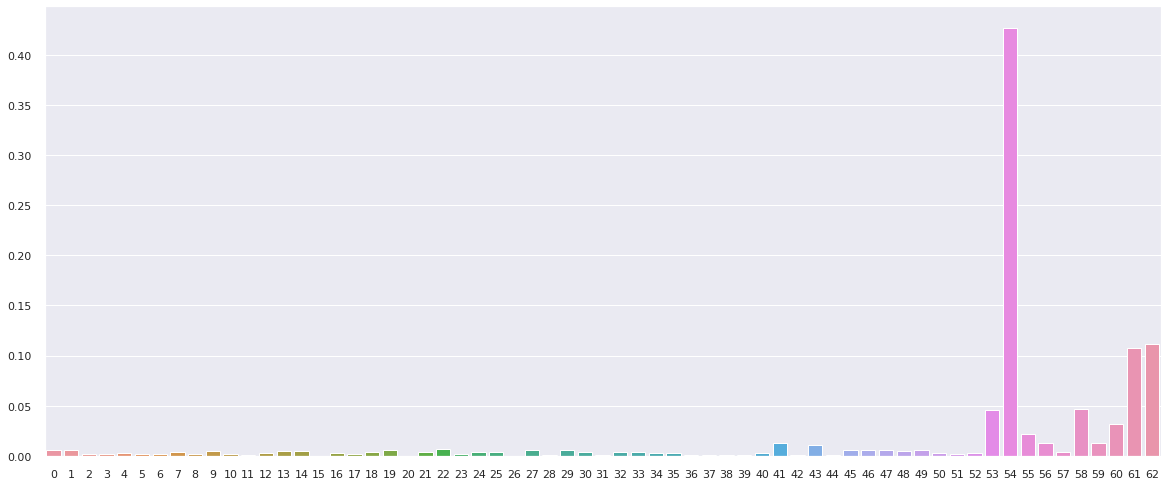

In [21]:
importance = classifier.feature_importances_
fig, ax = plt.subplots()
fig.set_size_inches(20, 8.27)
sns.barplot([x for x in range(len(importance))], importance, ax=ax)

Pricipais influenciadores (em ordem descrescente de importância): 
* Duração do contato
* Número de funcionários  
* Euribor
* Taxa de variação do emprego    
* Dia da semana    
* Índice de confiança do consumidor

## Predição de um novo registro

In [22]:
new_pred = [
  20,                   # idade
  'admin.',             # tipo de trabalho  (categorias: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
  'married',            # estado civil (categorias: 'divorced','married','single','unknown') observação: 'divorced' significa divorciado ou viúvo
  'basic.4y',           # educação (categorias:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') 
  'no',                 # tem crédito inadimplente? (categorias: 'no','yes','unknown')
  'no',                 # tem crédito habitacional? (categorias: 'no','yes','unknown')
  'no',                 # tem emprétimo pessoal? (categorias: 'no','yes','unknown')
  'telephone',          # tipo de comunicação do contato (categorias: 'cellular','telephone')
  'may',                # mês do último contato
  'mon',                # dia da semana do último contato (categorias: 'mon','tue','wed','thu','fri')
  300,                  # duração do último contato (em segundos)
  2,                    # quantidade de contatos realizados durante esta campanha e para este cliente (inclui último contato)
  999,                  # número de dias que passaram após o último contato do cliente de uma campanha anterior (999 significa que o cliente não foi contatado anteriormente)
  0,                    # quantidade de contatos realizados antes desta campanha e para este cliente
  'nonexistent',        # resultado da campanha de marketing anterior (categorias: 'failure','nonexistent','success')
  1.1,                  # taxa de variação do emprego
  90,                   # índice de preços ao consumidor
  -40,                  # índice de confiança do consumidor
  4.23,                 # euribor
  5200                  # número de funcionários
]

In [23]:
new_pred = np.array(ct.transform([new_pred]))
new_y = classifier.predict(new_pred)
print('Depósito a Prazo Realizado' if new_y[0] == 1 else 'Depósito a Prazo Não Realizado')

Depósito a Prazo Não Realizado
